# Explorative Analyse

Zunächst wird der originale Train-Datensatz explorativ analysiert und gegebenenfalls mit dem Test-Datensatz verglichen.

In [22]:
! pip install wordcloud
! pip install mlxtend




[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import numpy as np
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from PIL import Image
from sklearn.utils import resample
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

import tensorflow as tf
from sklearn.metrics import roc_auc_score, roc_curve,auc
from keras import regularizers
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,f1_score,classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from itertools import cycle

lemma = WordNetLemmatizer()
stopword = set(STOPWORDS)
nltk.download('omw-1.4')
%matplotlib inline
import nltk
nltk.download('stopwords')
import nltk
nltk.download('wordnet')


from nltk.corpus import brown
nltk.download("brown")
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\inteli\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inteli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\inteli\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\inteli\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [24]:
# df = pd.read_csv("..\\chris\\data\\train_cleaned_preprocessed.csv", index_col=0,
#                          encoding="utf-8-sig")
train_data = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\train.csv")
test_data = pd.read_csv("..\\..\\..\\data\\twitter_hate-speech\\test.csv")
train_data.sample(5)

,id,label,tweet
12088,12089,0,bedroom decorating is done! #myroomnow
16899,16900,0,these niggas will burn a bridge that can make ...
16586,16587,0,#countdown #ufcottawa here we come!!
1097,1098,0,#starsofthefuture loving the great dancing a...
21739,21740,0,today i broke my previous running record of 4....


In [25]:
train_data=train_data.drop(["id"],axis=1)
new_column=["tweet","label"]
train_data=train_data[new_column]
train_data=train_data.reindex(columns=new_column)
train_data.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [26]:
train_data['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

### Hate-Speech vs kein Hate-Speech

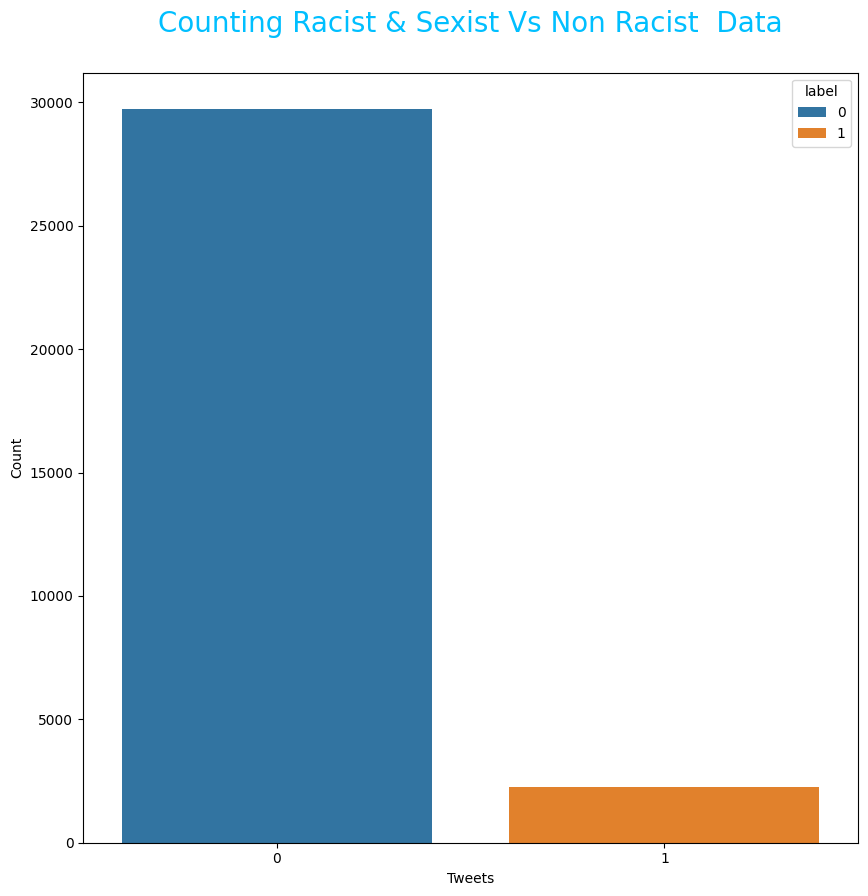

In [27]:
plt.figure(figsize=(10,10))
sns.countplot(data=train_data, x='label', hue='label')
plt.title("Counting Racist & Sexist Vs Non Racist  Data\n",fontsize=20,color="deepskyblue")
plt.xlabel('Tweets')
plt.ylabel("Count")
plt.show()

In [28]:
train_data_len = train_data['tweet'].str.len()
test_data_len = test_data['tweet'].str.len()

In [29]:
print("Train Text Data Length is",train_data_len)

Train Text Data Length is 0        102
1        122
2         21
3         86
4         39
        ... 
31957     68
31958    131
31959     63
31960     67
31961     32
Name: tweet, Length: 31962, dtype: int64


In [30]:
print("Test Text Data Length is",test_data_len)

Test Text Data Length is 0         90
1        101
2         71
3        142
4         93
        ... 
17192    108
17193     96
17194    145
17195    104
17196     64
Name: tweet, Length: 17197, dtype: int64


#### Train Data Length Vs Test Data Length

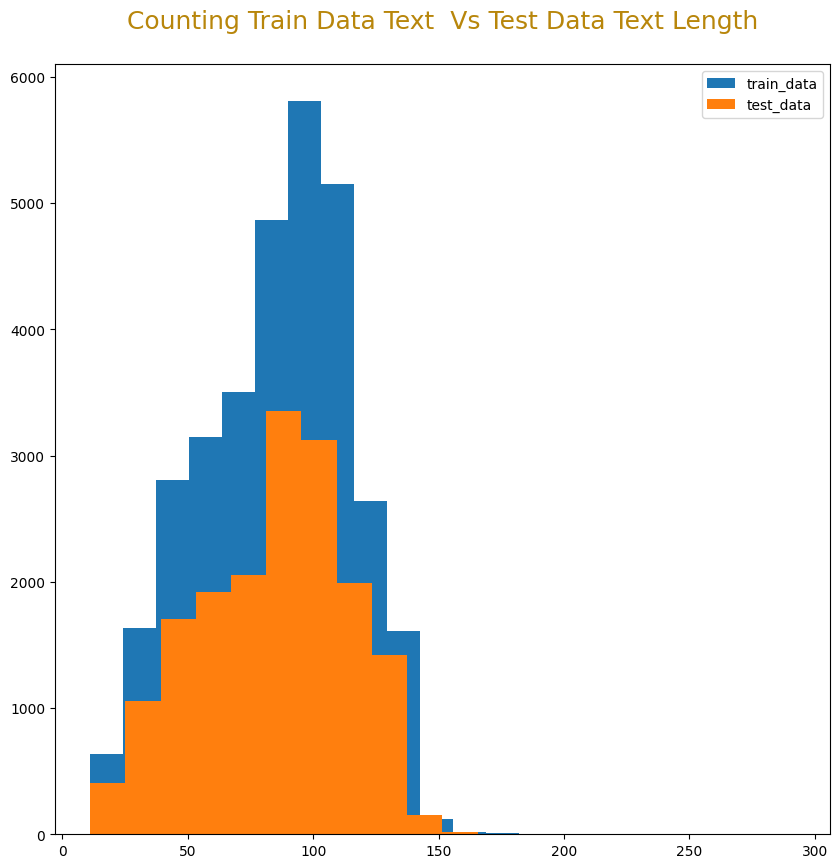

In [31]:
plt.figure(figsize=(10,10))
plt.hist(train_data_len, bins=20,label='train_data')
plt.hist(test_data_len , bins=20, label='test_data')
plt.title("Counting Train Data Text  Vs Test Data Text Length\n",fontsize=18,color="darkgoldenrod")
plt.legend()
plt.show()

Verteilung: Meiste Tweets zwischen 50-100 Zeichen.
Trainingsdaten vs. Testdaten: Trainingsdaten haben mehr längere Tweets.
Abnahme ab 100 Zeichen: Weniger Tweets über 100 Zeichen, vermutlich wegen Zeichenbegrenzung für kostenlose Nutzer.

### All Tweet Text Data WordCloud

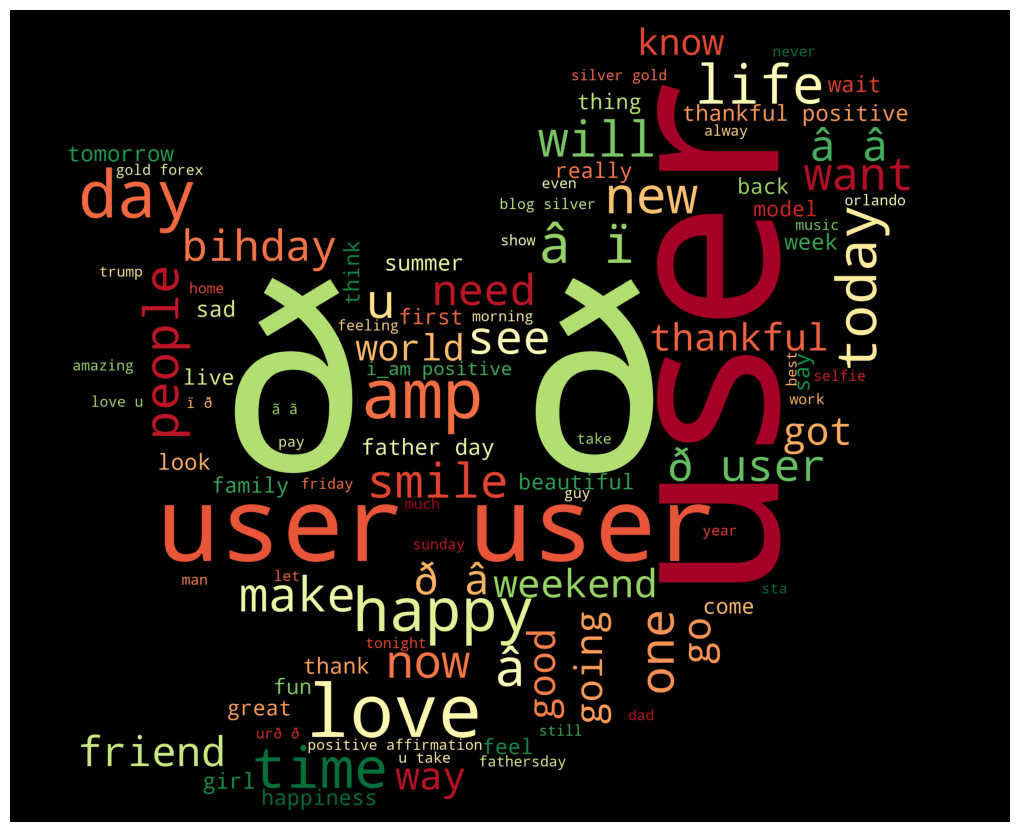

In [32]:
wordcloud_mask=np.array(Image.open("twitter.png"))
all_tweet_text=" ".join(train_data["tweet"].tolist())
plt.figure(figsize=(10,10))
wordcloud=WordCloud(stopwords=stopword,width=800,height=480,max_words=100,mask=wordcloud_mask,colormap='RdYlGn').generate(all_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

Häufige Wörter: "user," "day," "love," "life," "happy" – viele positive oder neutrale Themen.
Sonderzeichen: "ð," "â," "amp" – möglicherweise Kodierungsfehler, die bereinigt werden sollten.
Gefühle: Überwiegend positive Begriffe, was auf viele nicht-hassbezogene Tweets hindeutet.
Stoppwörter: Einige Stoppwörter wie "today" und "now" sind noch vorhanden.
Hassrede: Keine auffälligen Hassrede-Begriffe, mehr Fokus auf Alltagssprache aber wahrscheinlich wegen der Ungleichgewicht der Daten beider Klassen

### Positive (Hate-Speech) Tweet Text Data WordCloud

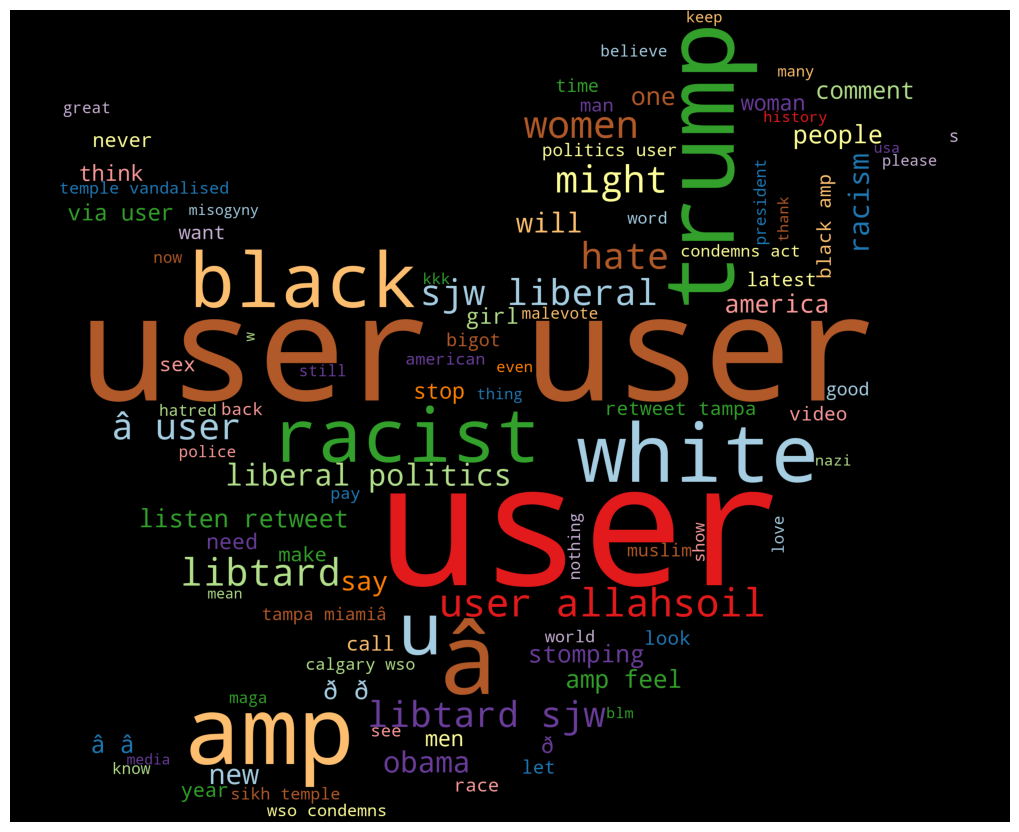

In [33]:
racist_sexist_data=train_data[train_data.label==1]
racist_tweet_text=" ".join(racist_sexist_data["tweet"].tolist())
plt.figure(figsize=(10,10))
wordcloud=WordCloud(stopwords=stopword,width=1600,height=800,max_words=100,mask=wordcloud_mask,colormap='Paired').generate(racist_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

Häufigste Wörter: "user," "trump," "racist," "white," "libtard."
Politische Begriffe: Wörter wie "trump," "liberal," "sjw" deuten auf politische Themen hin.
Hassrede: Worte wie "racist," "hate," "women," "black" weisen auf rassistische und sexistische Inhalte hin.
Abwertende Sprache: Begriffe wie "libtard," "sjw" und "bigot" werden oft in abfälligem Kontext verwendet.

### Negative (No Hate-Speech) Tweet Text Data WordCloud

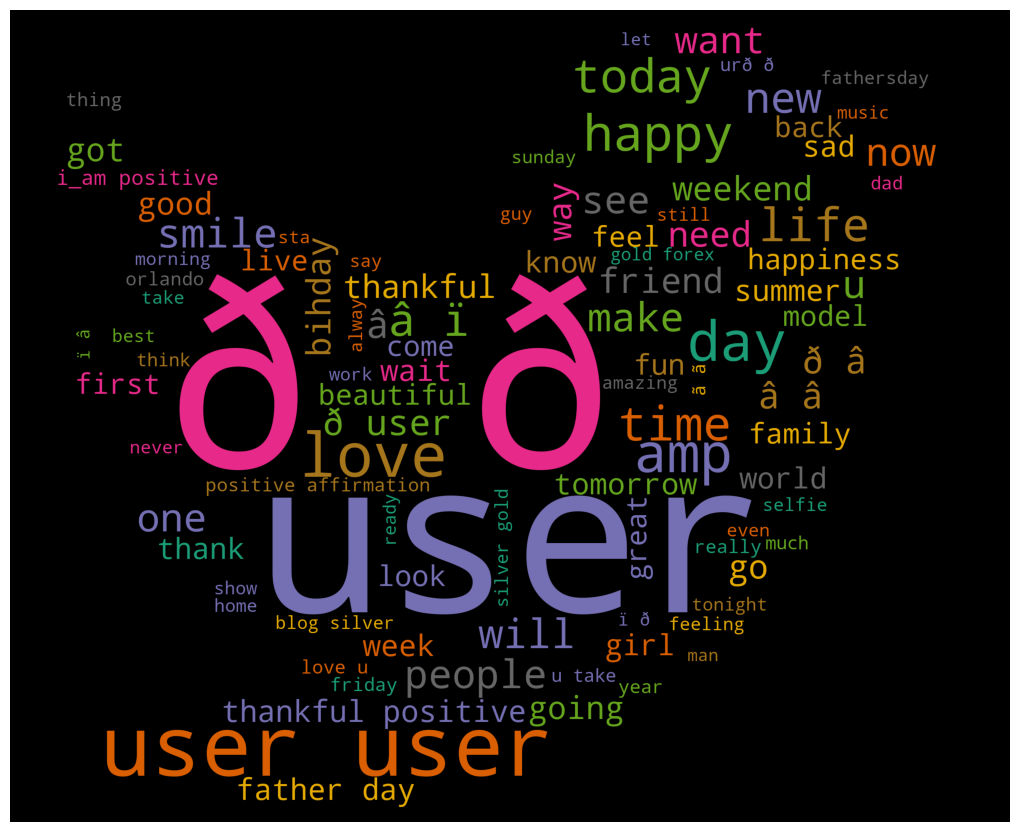

In [34]:
negative_data=train_data[train_data.label==0]
negative_tweet_text=" ".join(negative_data["tweet"].tolist())
plt.figure(figsize=(10,10))
wordcloud=WordCloud(stopwords=stopword,width=1600,height=800,max_words=100,mask=wordcloud_mask,colormap='Dark2').generate(negative_tweet_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

Häufigste Wörter: "user," "day," "happy," "love," "life."
Positiver Ton: Begriffe wie "happy," "love," "thankful," "smile" zeigen positive Themen.
Alltagsthemen: Wörter wie "family," "weekend," "today," "friend" deuten auf alltägliche und persönliche Inhalte hin.

### Most Frequent Words In Train Data

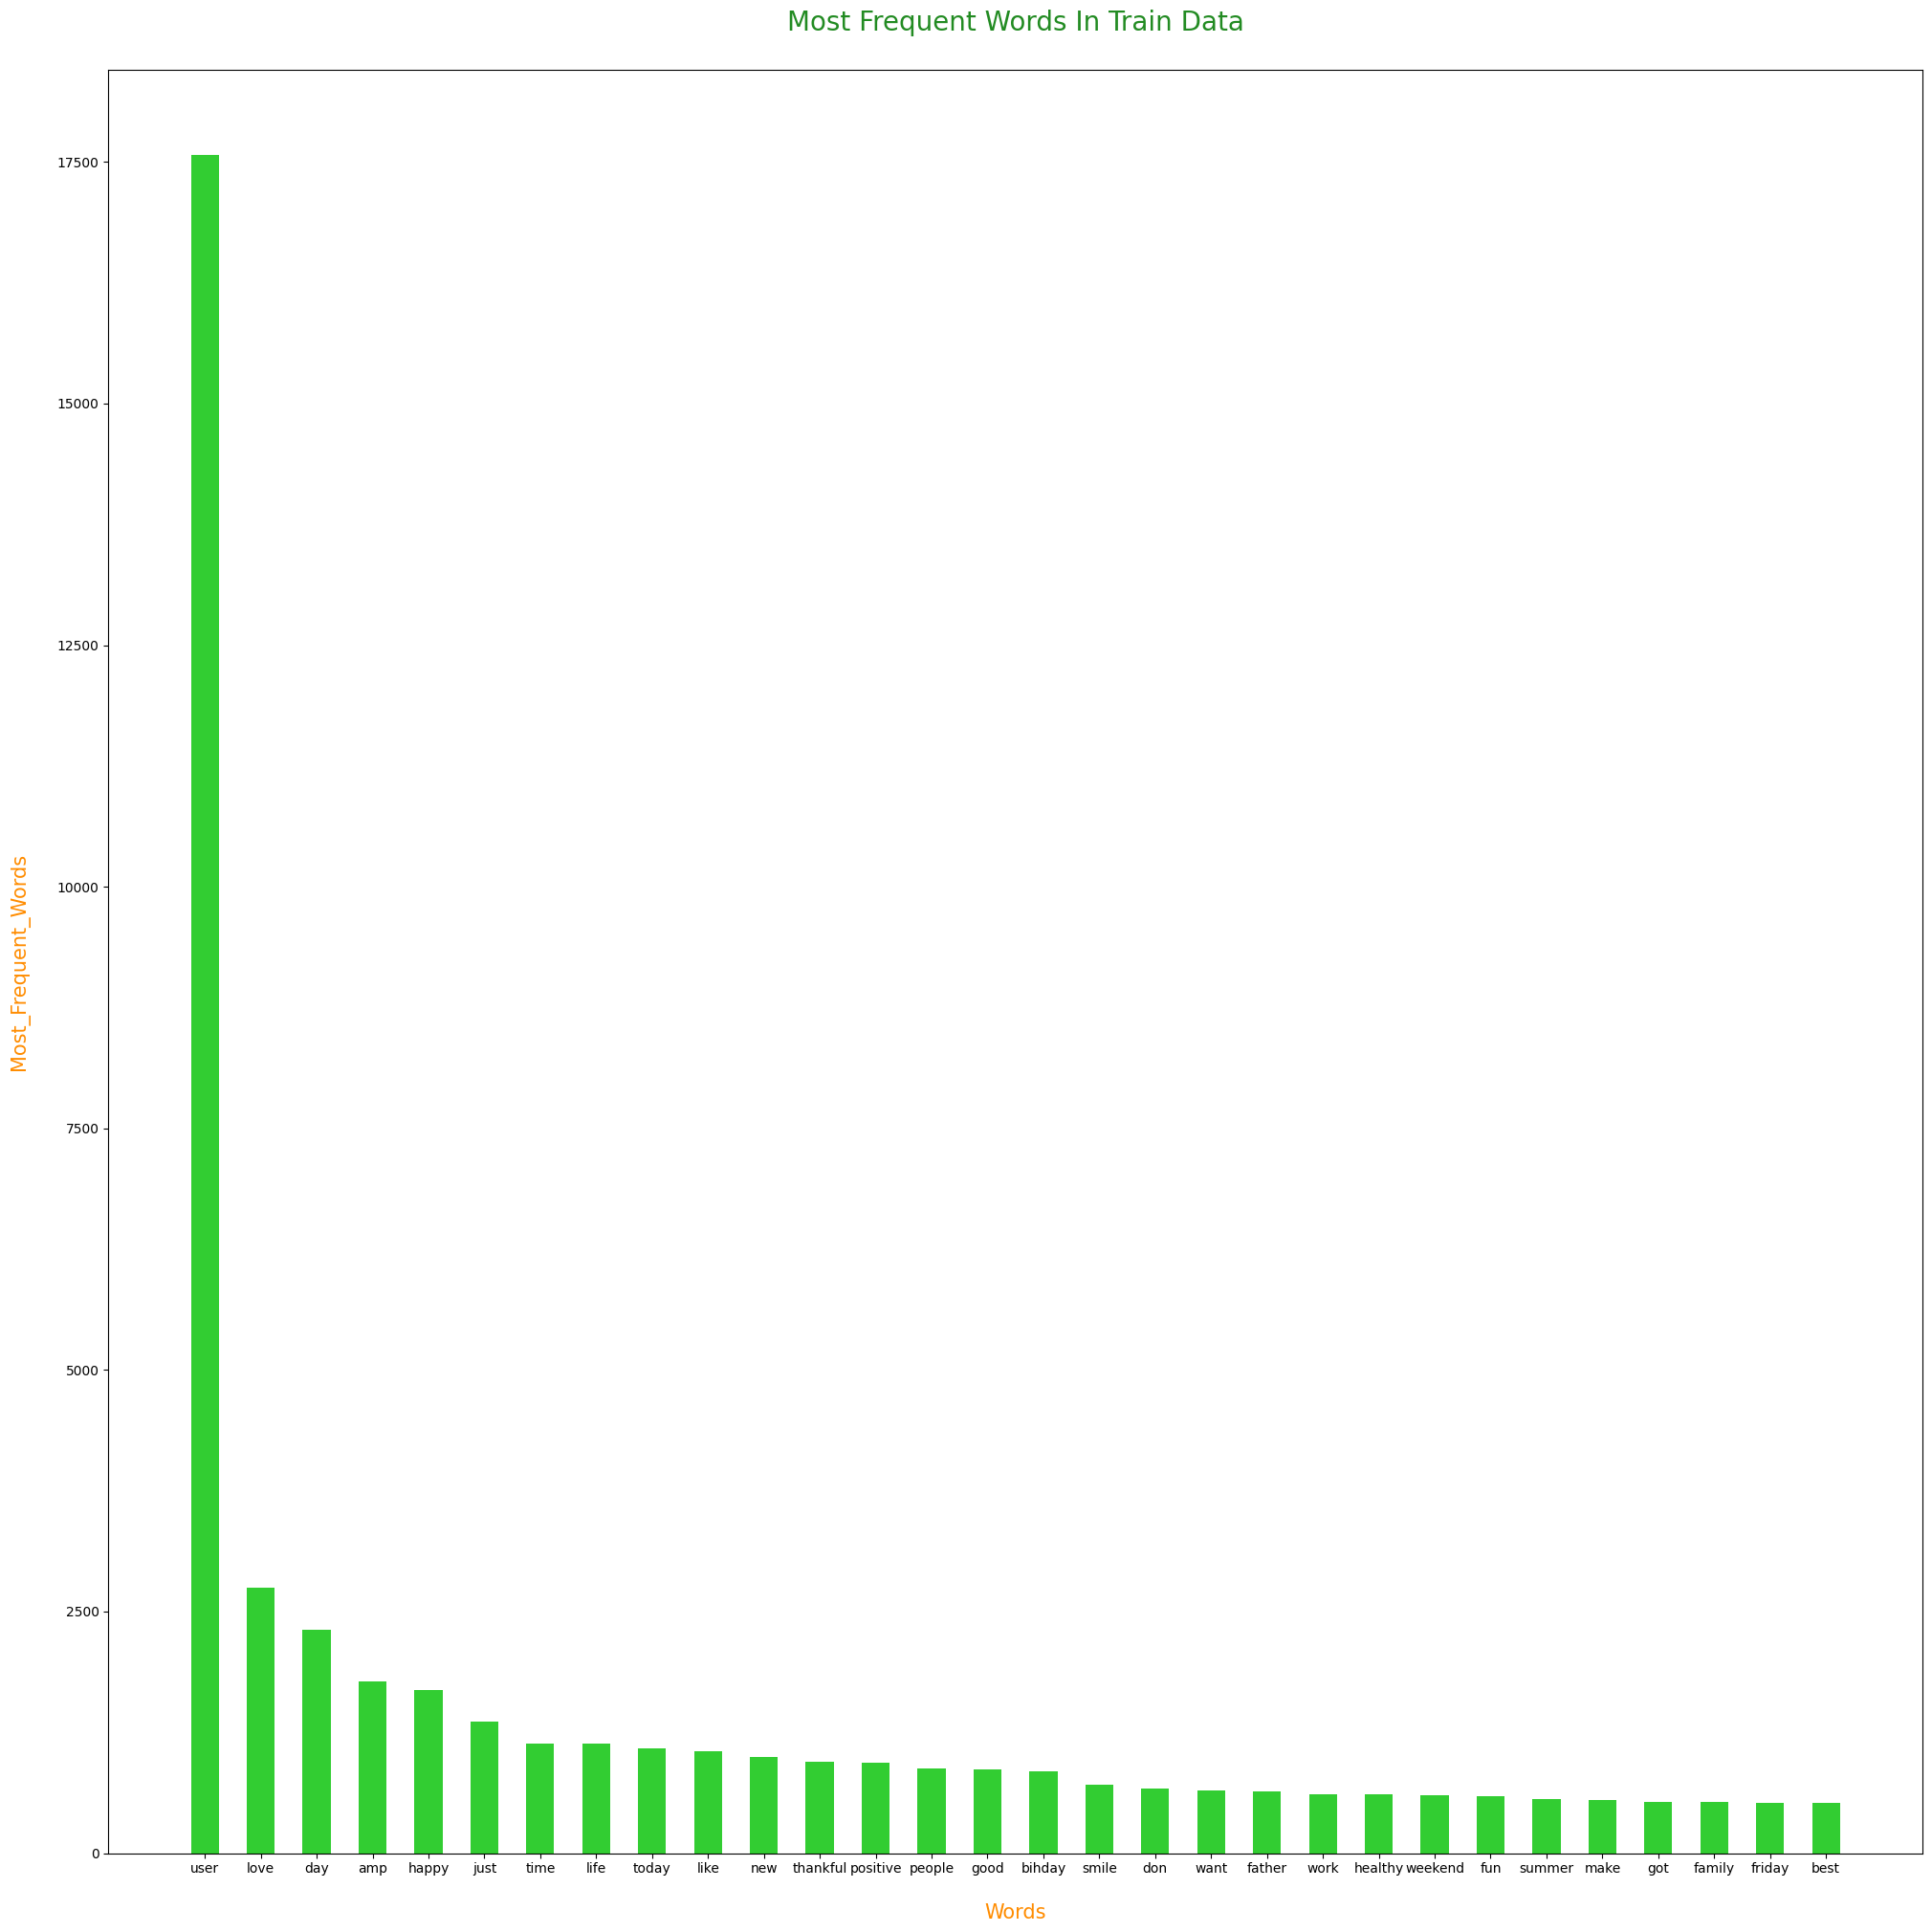

In [35]:
plt.figure(figsize=(20,20))
count_vectorizer=CountVectorizer(stop_words="english")
word=count_vectorizer.fit_transform(train_data.tweet)
sum_words=word.sum(axis=0)
most_freq_words=[(all_word,sum_words[0,i]) for all_word,i in count_vectorizer.vocabulary_.items()]
most_freq_words=sorted(most_freq_words,key=lambda x:x[1],reverse=True)

frequent_words=pd.DataFrame(most_freq_words,columns=["Words","Most_Frequent_Words"])

word_list = list(frequent_words.head(30).Words)
word_value_list = list(frequent_words.head(30).Most_Frequent_Words)

plt.bar(word_list, word_value_list, color ="limegreen",width=0.5)
plt.xlabel("\nWords",fontsize=15,color="darkorange")
plt.ylabel("Most_Frequent_Words\n",fontsize=15,color="darkorange")
plt.title("Most Frequent Words In Train Data\n",fontsize=20,color="forestgreen")
plt.tight_layout(pad=0)
plt.show()

## Data Preprocessing And Cleaning


import re
from nltk.corpus import stopwords

def clean_text(tweet):
    tweets = " ".join(filter(lambda x: x[0] != '@', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if word not in set(stopwords.words('english'))]
    tweets = " ".join(tweets)
    return tweets

In [36]:
import re
from nltk.corpus import stopwords

def clean_text(tweet):
    tweets = " ".join(filter(lambda x: x[0] != '@', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()
    tweets = [word for word in tweets if word not in set(stopwords.words('english'))]
    tweets = " ".join(tweets)
    return tweets

In [37]:
train_data['clean_tweet_text'] = train_data.tweet.apply(clean_text)

In [38]:
train_data.head()

,tweet,label,clean_tweet_text
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drags kids dysfun...
1,@user @user thanks for #lyft credit i can't us...,0,thanks lyft credit use cause offer wheelchair ...
2,bihday your majesty,0,bihday majesty
3,#model i love u take with u all the time in ...,0,model love u take u time ur
4,factsguide: society now #motivation,0,factsguide society motivation


### Extracting Hashtag Words

In [39]:
import re

def extract_hashtag(tweet):
    tweets = " ".join(filter(lambda x: x[0] == '#', tweet.split()))
    tweets = re.sub('[^a-zA-Z]', ' ', tweets)
    tweets = tweets.lower()
    tweets = tweets.split()  # Split into words
    tweets = " ".join(tweets)  # Rejoin words into a single string
    return tweets

In [40]:
train_data['word_with_hashtag'] = train_data.tweet.apply(extract_hashtag)


In [41]:
train_data.head()

,tweet,label,clean_tweet_text,word_with_hashtag
0,@user when a father is dysfunctional and is s...,0,father dysfunctional selfish drags kids dysfun...,run
1,@user @user thanks for #lyft credit i can't us...,0,thanks lyft credit use cause offer wheelchair ...,lyft disapointed getthanked
2,bihday your majesty,0,bihday majesty,
3,#model i love u take with u all the time in ...,0,model love u take u time ur,model
4,factsguide: society now #motivation,0,factsguide society motivation,motivation


### Most Common Positive (Hate-Speech) Words With Hashtag


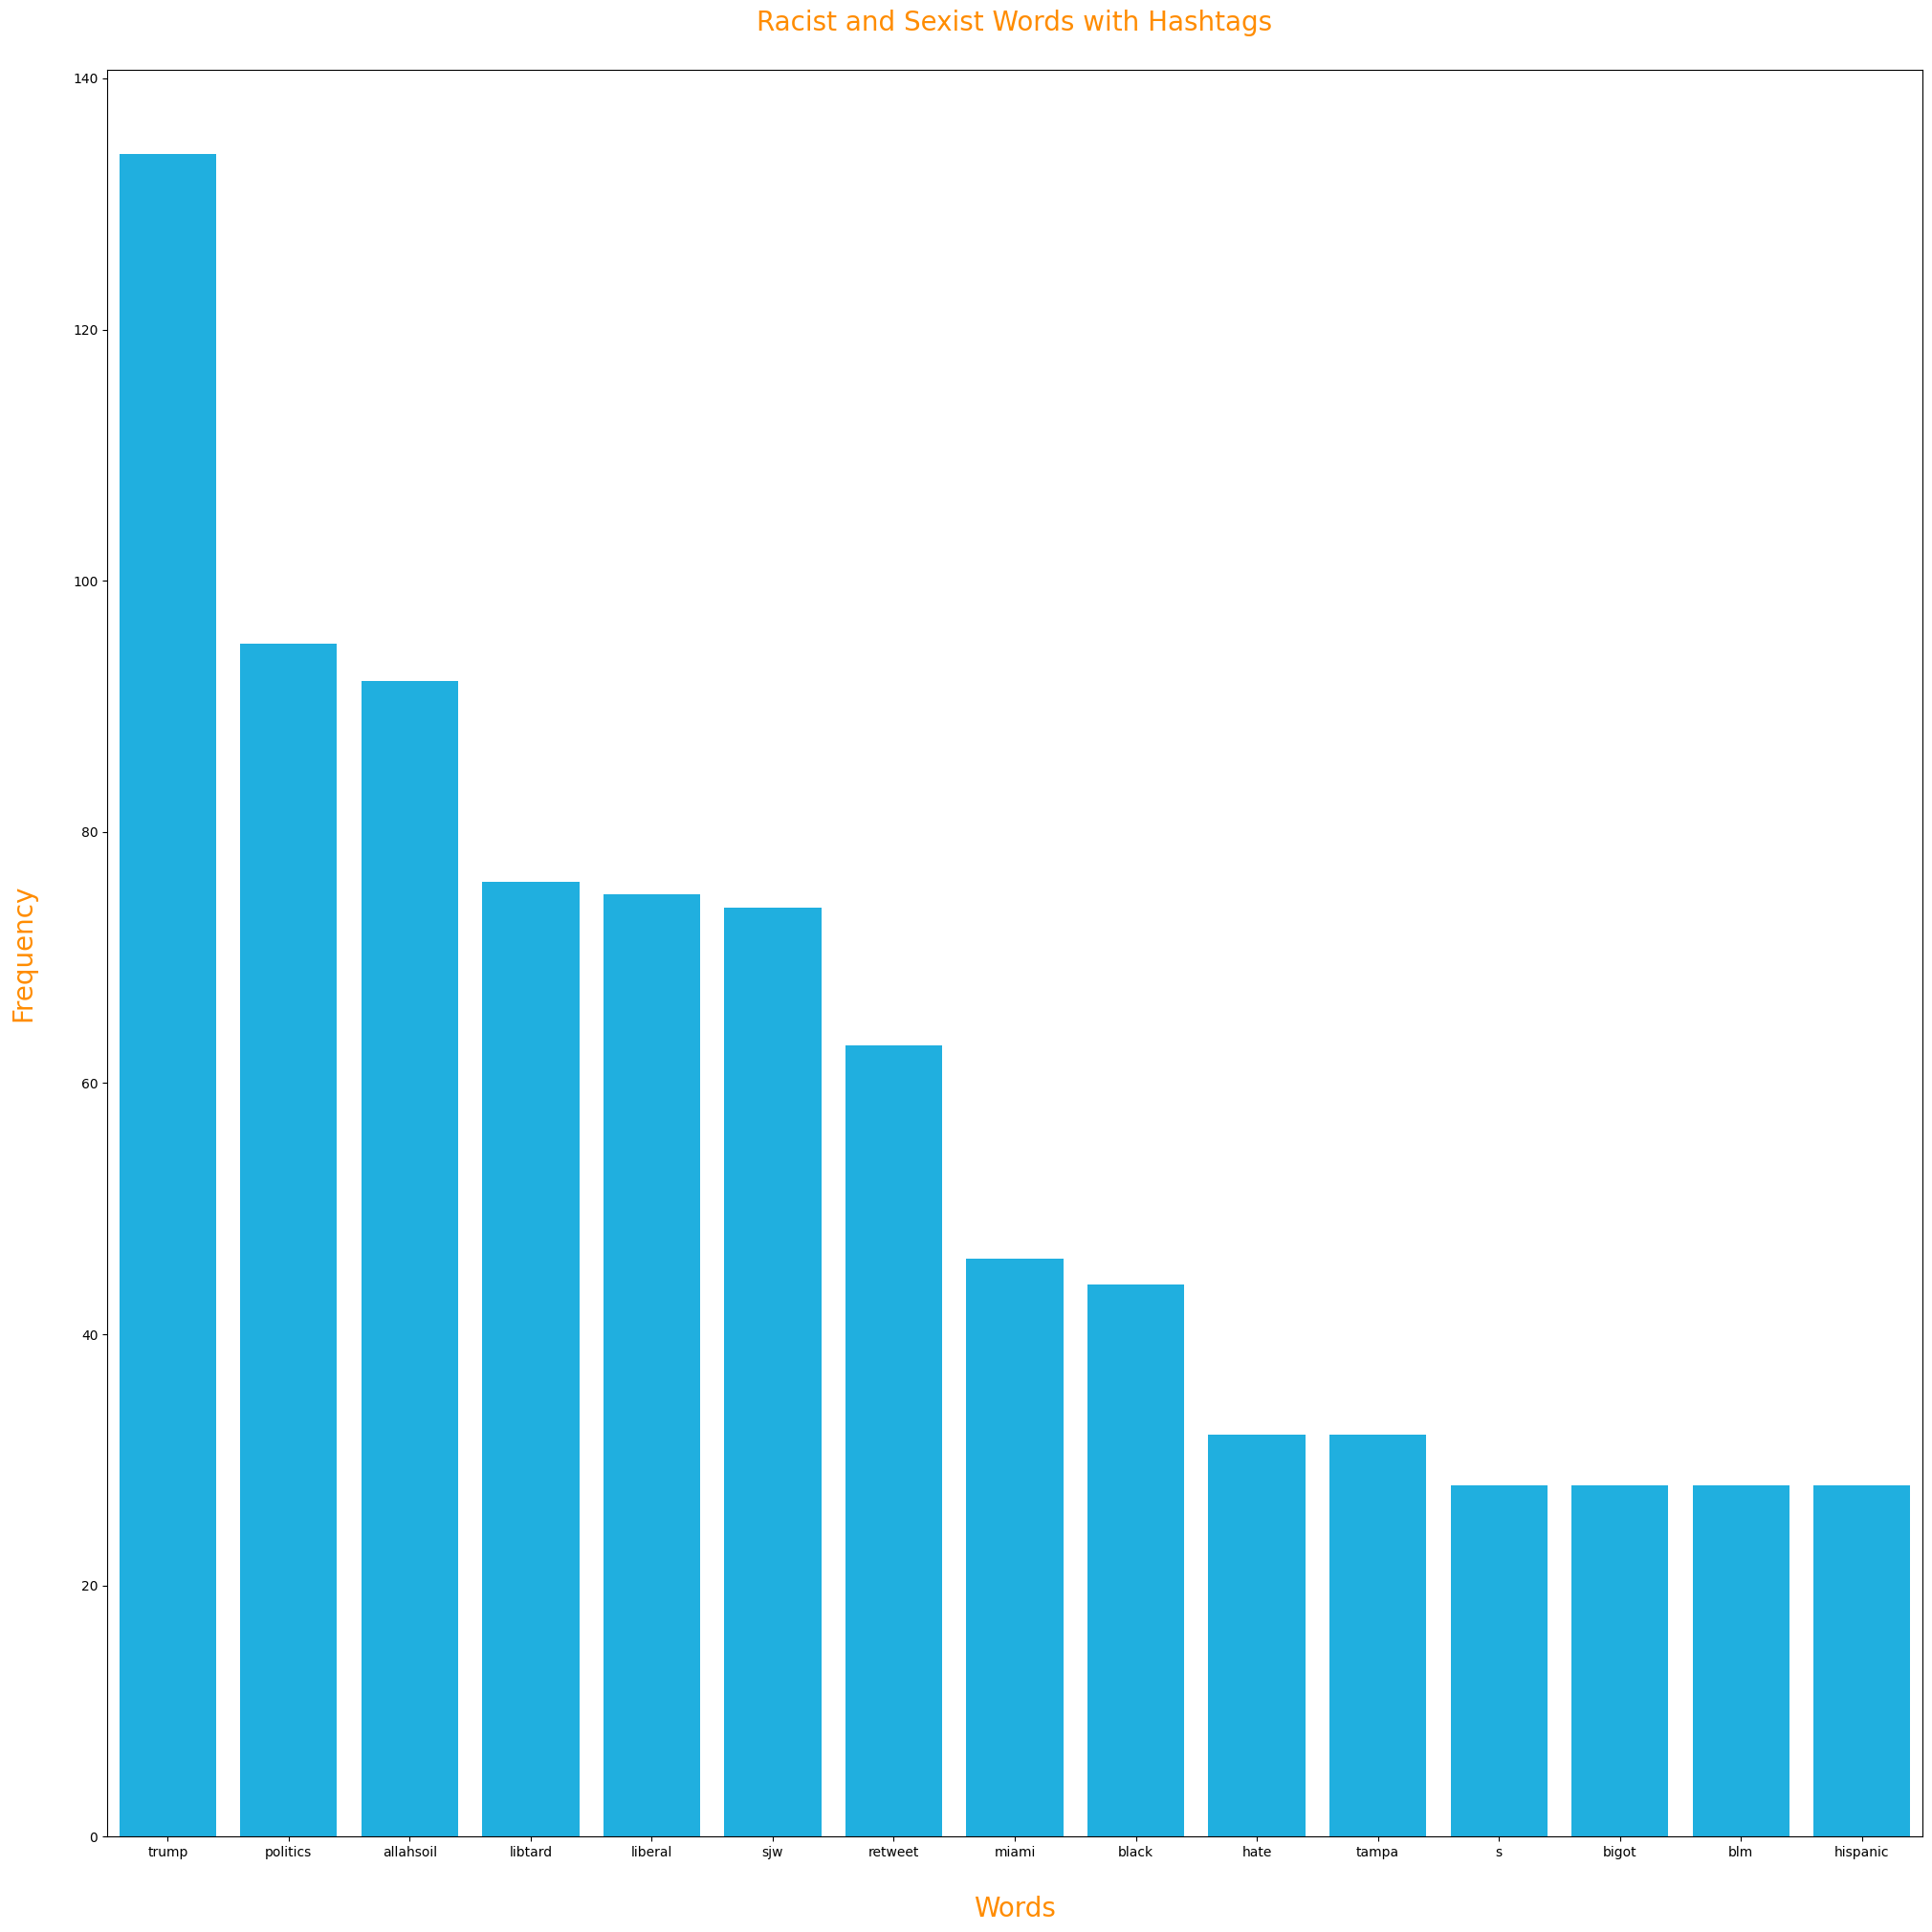

In [42]:
racist_sexist_hashtag = FreqDist(list(" ".join(train_data[train_data['label']==1]['word_with_hashtag']).split())).most_common(15)
racist_sexist_data = pd.DataFrame(racist_sexist_hashtag, columns=['words', 'frequency'])
plt.figure(figsize=(20,20))
sns.barplot(x='words',y="frequency" ,data=racist_sexist_data,color="deepskyblue")

plt.title('Racist and Sexist Words with Hashtags\n',fontsize=20,color="darkorange")
plt.xlabel("\nWords",fontsize=20,color="darkorange")
plt.ylabel("Frequency\n",fontsize=20,color="darkorange")
plt.tight_layout(pad=0)
plt.show()

### Most Common Negative (Hate-Speech) Words With Hashtag


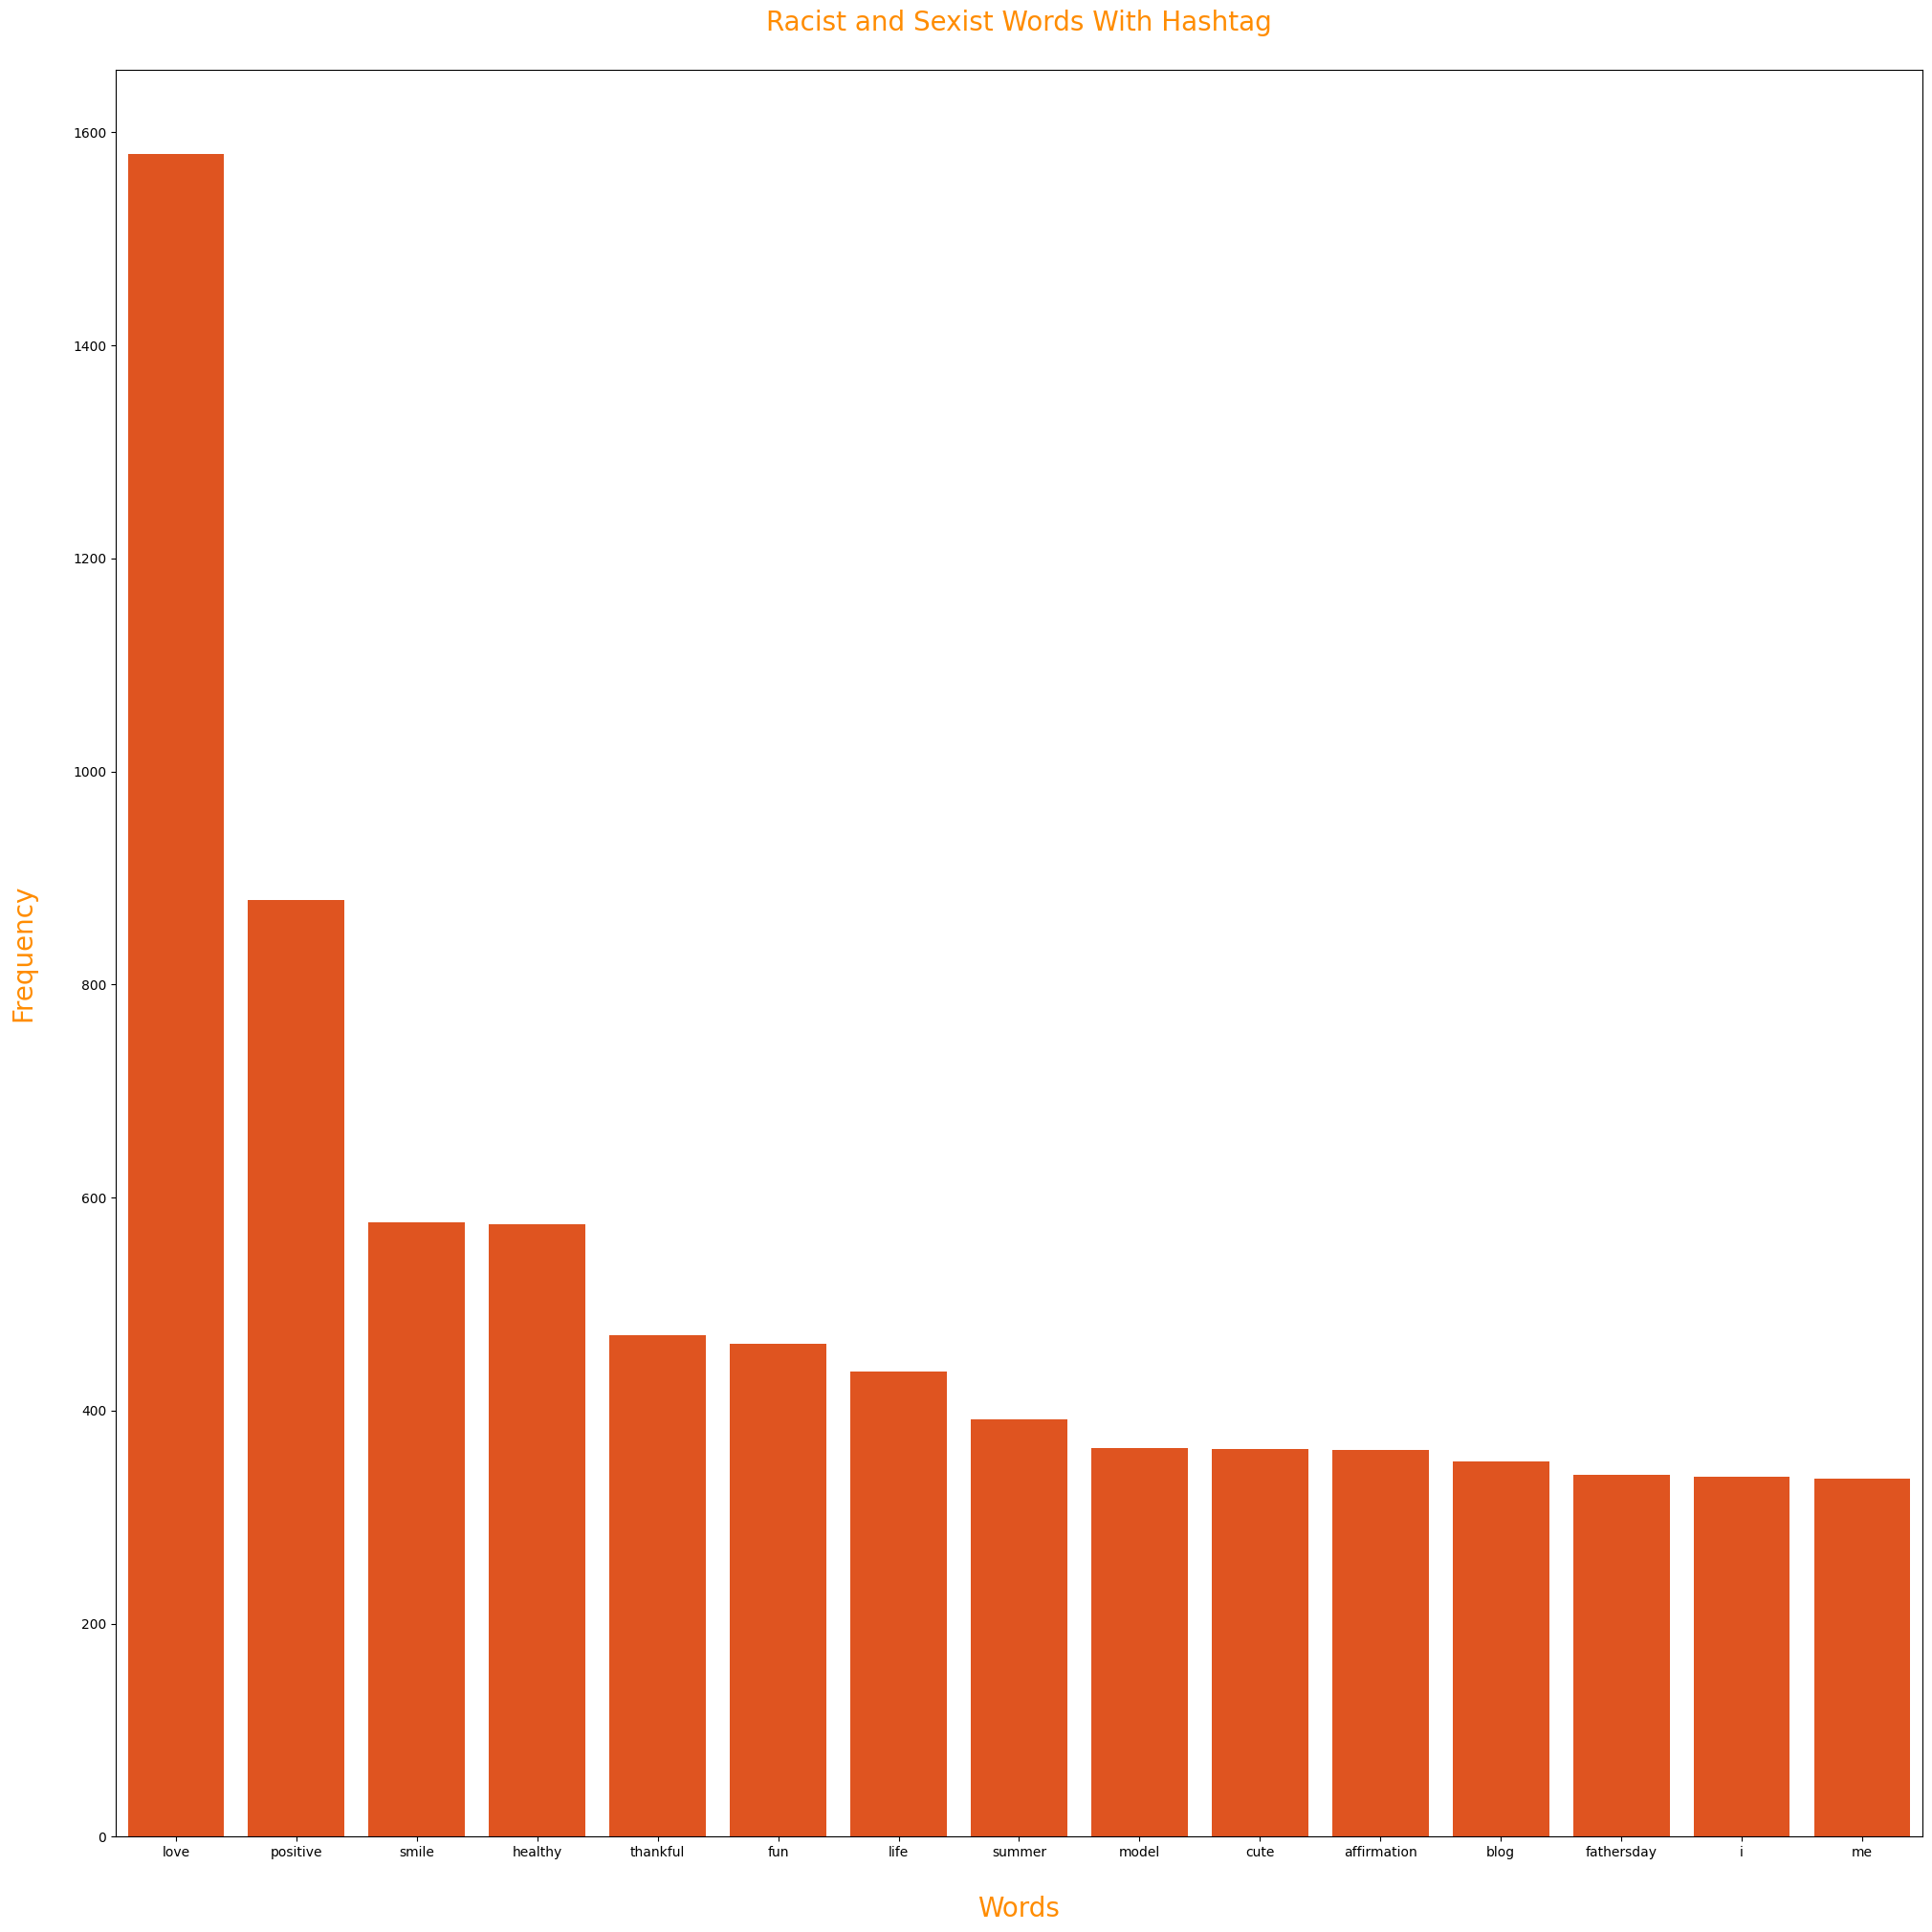

In [43]:
positive_hashtag = FreqDist(list(" ".join(train_data[train_data['label']==0]['word_with_hashtag']).split())).most_common(15)
positive_data = pd.DataFrame(positive_hashtag, columns=['words', 'frequency'])
plt.figure(figsize=(20,20))
sns.barplot(x='words',y="frequency" ,data=positive_data,color="orangered")

plt.title('Racist and Sexist Words With Hashtag\n',fontsize=20,color="darkorange")
plt.xlabel("\nWords",fontsize=20,color="darkorange")
plt.ylabel("Frequency\n",fontsize=20,color="darkorange")
plt.tight_layout(pad=0)
plt.show()